# Import stuff

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import tensorflow as tf
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import enchant
from sklearn.feature_extraction.text import CountVectorizer

# Dataset Preparation

In [ ]:
true = pd.read_csv('../raw_data/True.csv')
fake = pd.read_csv('../raw_data/Fake.csv')

In [ ]:
true.drop(columns = ['subject','date'], inplace = True)
fake.drop(columns = ['subject','date'], inplace = True)

In [4]:
true['score'] = 1
fake['score'] = 0

In [5]:
stop_words = ['/Getty Images','(Reuters)','https']
pat = '|'.join(r"\b{}\b".format(x) for x in stop_words)
fake['text'] = fake['text'].str.replace(pat, '')
true['text'] = true['text'].str.replace(pat, '')

In [6]:
data = pd.concat([true,fake],ignore_index=True)

In [7]:
margarida_fake = pd.read_csv('../raw_data/fake_extra.csv')
margarida_fake.dropna(inplace = True)
margarida_fake.shape

business_insider_true = pd.read_csv('../raw_data/Business_Insider.csv', nrows = 5000)
business_insider_true.dropna(inplace = True)
business_insider_true.shape

washington_post_true = pd.read_csv('../raw_data/Washington_Post.csv', nrows = 5000)
washington_post_true.dropna(inplace = True)
washington_post_true.shape

(5000, 3)

In [8]:
margarida_fake['score'] = 0

business_insider_true['score'] = 1

washington_post_true['score'] = 1

In [9]:
margarida_fake=margarida_fake[['title','text']]

In [10]:
data = pd.concat([true,fake, margarida_fake, business_insider_true, washington_post_true],ignore_index=True)

/Users/andreamontagnoli/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [12]:
data=data[['text','title','score']]


In [48]:
data.dropna(inplace = True)

# Cleaning

In [49]:
stop_words = ['/Getty Images','(Reuters)','https']
pat = '|'.join(r"\b{}\b".format(x) for x in stop_words)
data['text'] = data['text'].str.replace(pat, '')

In [50]:
import string

punc = string.punctuation + '“' + '”' + '’' + '‘' + '—'
punc_no_sq='!"#$%&\()*+,./:;<=>?@[\\]^_`{|}~“”—'
def remove_punctuation(text):
    for punctuation in punc_no_sq:
        text = text.replace(punctuation, ' ')
    return text

def remove_numbers(text):
    text = ''.join(word for word in text if not word.isdigit())
    return text



In [51]:
# Remove numbers
data['title_clean']=data['title'].apply(remove_numbers)

data['text_clean']=data['text'].apply(remove_numbers)

In [52]:
# bikkuri count and ratio
import collections as ct

def count_bikkuri(text):
    bikkuri=0
    for element in text:
        if element=="!":
            bikkuri+=1
    return bikkuri        
#     terminals = "!"
#     bikkuri = {c:val for c, val in ct.Counter(text).items() if c in terminals}
#     bikkuri_count=list(bikkuri.values())[0]
#     return bikkuri_count    

punc = string.punctuation + '“' + '”' + '’' + '‘'
def count_punctuation(text):
    total_punct=0
    for punctuation in text:
        if punctuation in punc:
            total_punct+=1
    return total_punct        

data['bikkuri_count']=data['text_clean'].apply(count_bikkuri)
data['bikkuri_ratio']=data['bikkuri_count']/data['text_clean'].apply(count_punctuation)


In [53]:
# Remove punctuation to title

data['title_clean']=data['title_clean'].apply(remove_punctuation)

In [54]:
# Remove punctuation to text

data['text_clean']=data['text_clean'].apply(remove_punctuation)

In [55]:
# Stop words removal
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
data['title_clean'] = data['title_clean'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in (stop_words)]))
data['text_clean'] = data['text_clean'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in (stop_words)]))

In [56]:
#Tokenize Text

def tokenize_text(text):
    return text.split()
data['title_tokens']=data['title_clean'].apply(tokenize_text)
data['text_tokens']=data['text_clean'].apply(tokenize_text)

In [57]:
# Define a function to find wrong words and return the count

english = enchant.DictWithPWL("en_US", "vocab.txt")
wrong_words={}
correct_words=set()
def get_typos_t(tokens):
     wrong_count=0
     for token in tokens:
            if token in wrong_words:
                wrong_words[token]+=1
                wrong_count+=1
            else:
                if not token in correct_words:    
                    if token[0].islower() and not '-' in token and not english.check(token) and not english.check(token.capitalize()):
                        wrong_words[token]=1
                        wrong_count+=1
                    else:
                        correct_words.add(token)
     return wrong_count    


In [58]:
# Defining a function to get tokens in text
def get_tokens_text(df):
    get_tokens = set()
    for text in df['text']:
        split_text = text.split()
        for token in split_text:
            get_tokens.add(token)
    return get_tokens

tokens_fake = get_tokens_text(fake)
tokens_true = get_tokens_text(true)

In [59]:
print(len(tokens_fake),len(tokens_true))

293392 178494


# Create new features

In [60]:
data['title_token_count']=data['title_tokens'].apply(lambda tokens:len(tokens))
data['text_token_count']=data['text_tokens'].apply(lambda tokens:len(tokens))

In [61]:
data['wrong_title_token_count']=data['title_tokens'].apply(get_typos_t)
data['wrong_text_token_count']=data['text_tokens'].apply(get_typos_t)

In [62]:
def rem_urls(text):
    return re.sub('https?:\S+','',text)

data['text'] = data['text'].apply(rem_urls)
data['title'] = data['title'].apply(rem_urls)

In [63]:
{k: v for k, v in sorted(wrong_words.items(), key=lambda item: item[1],reverse=True)}

{'realDonaldTrump': 4798,
 'de': 1622,
 'cyber': 1564,
 'js': 1170,
 'it’’s': 984,
 'don’’t': 909,
 'www': 780,
 'youtube': 768,
 'ite': 607,
 'screengrab': 528,
 'fjs': 522,
 'frontrunner': 509,
 'that’’s': 465,
 'didn’’t': 459,
 'youtu': 403,
 'you’’re': 365,
 'ly': 356,
 'doesn’’t': 355,
 'opioid': 354,
 'he’’s': 350,
 'counterterrorism': 347,
 'tmsnrt': 338,
 'hardline': 335,
 'facto': 309,
 'millennials': 304,
 'we’’re': 302,
 'microcephaly': 301,
 'cybersecurity': 288,
 'they’’re': 279,
 'can’’t': 275,
 'there’’s': 264,
 'cking': 254,
 'protestors': 238,
 'seanhannity': 233,
 'washingtonpost': 226,
 'src': 218,
 'getElementById': 213,
 'amongst': 211,
 'getElementsByTagName': 211,
 'cancelled': 210,
 'createElement': 210,
 'superdelegates': 201,
 'parentNode': 182,
 'insertBefore': 179,
 'ers': 174,
 'xfbml': 174,
 'isn’’t': 174,
 'leakers': 173,
 'sdk': 173,
 'whistleblower': 169,
 'nytimes': 168,
 'responders': 167,
 'sarin': 165,
 'biofuels': 163,
 'foxandfriends': 161,
 'defe

In [64]:
data['title_typo_ratio']= data['wrong_title_token_count']/data['title_token_count']
data['text_typo_ratio']= data['wrong_text_token_count']/data['text_token_count']


In [65]:
data['text'][3]

'WASHINGTON () - Trump campaign adviser George Papadopoulos told an Australian diplomat in May 2016 that Russia had political dirt on Democratic presidential candidate Hillary Clinton, the New York Times reported on Saturday. The conversation between Papadopoulos and the diplomat, Alexander Downer, in London was a driving factor behind the FBI’s decision to open a counter-intelligence investigation of Moscow’s contacts with the Trump campaign, the Times reported. Two months after the meeting, Australian officials passed the information that came from Papadopoulos to their American counterparts when leaked Democratic emails began appearing online, according to the newspaper, which cited four current and former U.S. and foreign officials. Besides the information from the Australians, the probe by the Federal Bureau of Investigation was also propelled by intelligence from other friendly governments, including the British and Dutch, the Times said. Papadopoulos, a Chicago-based internation

# Plotting

<AxesSubplot:xlabel='score', ylabel='title_typo_ratio'>

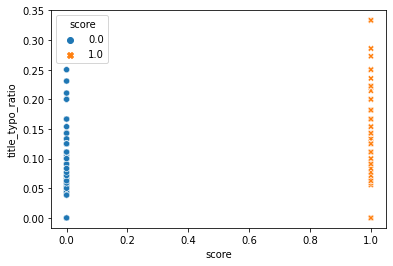

In [66]:
sns.scatterplot(data=data, x="score", y="title_typo_ratio", hue="score", style="score")

<AxesSubplot:xlabel='score', ylabel='text_typo_ratio'>

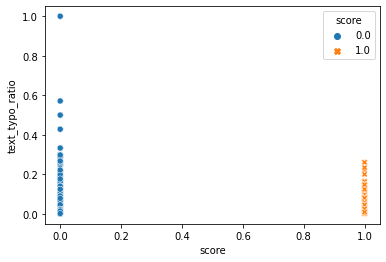

In [67]:
sns.scatterplot(data=data, x="score", y="text_typo_ratio", hue="score", style="score")

<AxesSubplot:xlabel='score', ylabel='bikkuri_ratio'>

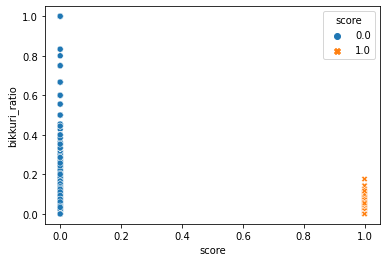

In [68]:
sns.scatterplot(data=data, x="score", y="bikkuri_ratio", hue="score", style="score")

In [69]:
data_clean = data[['title', 'text', 'title_clean', 'text_clean','title_tokens',
       'bikkuri_ratio','text_typo_ratio','score']].copy()

In [70]:
# data_clean = data[['title', 'text', 'title_clean', 'text_clean','title_tokens',
#        'text_tokens','text_typo_ratio', 'bikkuri_ratio','score']].copy()

# Define Generic Function

In [71]:
def preparation(data):
    data['title_clean']=data['title'].apply(remove_numbers)
    data['text_clean']=data['text'].apply(remove_numbers)
    
    data['bikkuri_count']=data['text_clean'].apply(count_bikkuri)
    data['bikkuri_ratio']=data['bikkuri_count']/data['text_clean'].apply(count_punctuation)
    
    data['title_clean']=data['title_clean'].apply(remove_punctuation)
    data['text_clean']=data['text_clean'].apply(remove_punctuation)
    
    data['title_clean'] = data['title_clean'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in (stop_words)]))
    data['text_clean'] = data['text_clean'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in (stop_words)]))
    
    data['title_tokens']=data['title_clean'].apply(tokenize_text)
    data['text_tokens']=data['text_clean'].apply(tokenize_text)
    
    data['title_token_count']=data['title_tokens'].apply(lambda tokens:len(tokens))
    data['text_token_count']=data['text_tokens'].apply(lambda tokens:len(tokens))
    
    data['wrong_title_token_count']=data['title_tokens'].apply(get_typos_t)
    data['wrong_text_token_count']=data['text_tokens'].apply(get_typos_t)
    
    data['title_typo_ratio']= data['wrong_title_token_count']/data['title_token_count']
    data['text_typo_ratio']= data['wrong_text_token_count']/data['text_token_count']
    
    return data[['title_clean', 'text_clean','text_typo_ratio']]
    

# Clean logistic Regression

In [72]:
y=data['score']

In [73]:
# feature_cols = ['title', 'text', 'title_clean', 'text_clean','title_tokens',
#        'text_tokens','text_typo_ratio']
feature_cols = ['title_clean', 'text_clean','text_typo_ratio']

x=data_clean[feature_cols]

In [74]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=0,test_size=0.3)

In [75]:
x_train.head()

,title_clean,text_clean,text_typo_ratio
54297,Obama delivers forceful statement shooting pol...,’ ’ ’ President Barack Obama condemned left le...,0.000000
24493,Madonna Gets REAL Trump’s Presidency Brilliant...,Madonna never shy expressing fact hates Presid...,0.005263
28846,Watch Desperate Americans Literally BEG Justin...,Canadian Prime Minister Justin Trudeau continu...,0.041139
1102,Trump tax cut plan gains momentum U budget vote,WASHINGTON - President Donald Trump’s tax refo...,0.000000
3193,Trump name Republican donor Kelly Craft ambass...,WASHINGTON - President Donald Trump decided na...,0.000000


In [76]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
preprocessor = ColumnTransformer([
    ('vectorizer_title', CountVectorizer(), 'title_clean'),
    ('vectorizer_text', CountVectorizer(), 'text_clean'),

])
final_pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('Logistic', LogisticRegression())])

In [77]:
final_pipe.fit(x_train,y_train)

/Users/andreamontagnoli/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
     steps=[('preprocessing', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('vectorizer_title', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', ...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [78]:
final_pipe.score(x_test,y_test)

0.9854279390063945

In [ ]:
y_test.shape

In [ ]:
# test= '''President Donald Trump is trying to steal a free and fair election that he lost by a wide margin to President-elect Joe Biden by tearing at the most basic principle of American democracy: He's trying to throw out hundreds of thousands of votes.
# Trump's latest escalation of his attempt to subvert the result of the election followed a string of knock-backs in the courts and after a statewide audit in Georgia confirmed Biden's victory in the crucial swing state.
# He asked state Republican leaders in Michigan to visit him Friday, hinting at a possible attempt to convince them to ignore Biden's big win in the state and send a slate of electors to the Electoral College that backs him and not the President-elect. Both Michigan House Speaker Lee Chatfield and Senate Majority Leader Mike Shirkey will meet with Trump at the White House at 4 p.m. ET, according to a source familiar with the plans.
# This follows the President's calls to two Wayne County GOP officials, who are now seeking to take back their votes to certify Biden's victory.
# Trump's lawyer, Rudy Giuliani, who rampaged through an unhinged news conference Thursday, is in effect baselessly arguing that troves of Democratic mail-in ballots, many of them cast by Black voters, are illegal and that Trump has therefore won the election with room to spare.
# "It changes the result of the election in Michigan if you take out Wayne County," Giuliani said at a crowded, mask-free and delusional news conference featuring Trump's crew of TV lawyers in Washington.
# Giuliani's team is also making absurd claims of a massive, centralized, Democratic conspiracy involving long-dead Venezuelan dictator Hugo Chavez, Cuba, China, the Clinton Foundation and George Soros to throw the election.'''

In [ ]:
# title="Trump undercuts American democracy as he clings to power"
# test_series=pd.Series(test)
# title_series=pd.Series(title)

In [ ]:
# test_df=pd.DataFrame({'title_clean':title_series,'text_clean':test_series, 'text_typo_ratio':[0.1]})

In [ ]:
fake_test = pd.read_csv('../raw_data/fake_extra.csv')

In [ ]:
#fake_test = fake_test.replace(np.nan, '', regex=True)
fake_test=fake_test.dropna()

In [ ]:
result=final_pipe.predict(preparation(fake_test))

In [ ]:
unique, counts = np.unique(result, return_counts=True)
dict(zip(unique, counts))


# Create DB of real news

In [ ]:
real_test = pd.read_csv('../raw_data/articles1.csv')

In [ ]:
real_test=fake_test.dropna()

In [ ]:
washington_post=real_test.loc[real_test['publication'] == 'Washington Post']

# Trying some extra data

In [99]:
real_test = pd.read_csv('../raw_data/articles1.csv')

In [100]:
#real_test=fake_test.dropna()

In [101]:
#result_real=final_pipe.predict(preparation(real_test))

In [102]:
# unique, counts = np.unique(result_real, return_counts=True)
# dict(zip(unique, counts))

In [103]:
new_york_real=real_test.loc[real_test['publication'] == 'New York Times']
new_york_real
# real_test['publication']

,Unnamed: 0,id,title,publication,author,date,year,month,url,content
0,0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,NaN,WASHINGTON — Congressional Republicans have...
1,1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,NaN,"After the bullet shells get counted, the blood..."
2,2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,NaN,"When Walt Disney’s “Bambi” opened in 1942, cri..."
3,3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,NaN,"Death may be the great equalizer, but it isn’t..."
4,4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,NaN,"SEOUL, South Korea — North Korea’s leader, ..."
5,5,17288,"Sick With a Cold, Queen Elizabeth Misses New Y...",New York Times,Sewell Chan,2017-01-02,2017.0,1.0,NaN,"LONDON — Queen Elizabeth II, who has been b..."
6,6,17289,Taiwan’s President Accuses China of Renewed In...,New York Times,Javier C. Hernández,2017-01-02,2017.0,1.0,NaN,BEIJING — President Tsai of Taiwan sharpl...
7,7,17290,"After ‘The Biggest Loser,’ Their Bodies Fought...",New York Times,Gina Kolata,2017-02-08,2017.0,2.0,NaN,"Danny Cahill stood, slightly dazed, in a blizz..."
8,8,17291,"First, a Mixtape. Then a Romance. - The New Yo...",New York Times,Katherine Rosman,2016-12-31,2016.0,12.0,NaN,"Just how is Hillary Kerr, the founder of ..."
9,9,17292,Calling on Angels While Enduring the Trials of...,New York Times,Andy Newman,2016-12-31,2016.0,12.0,NaN,Angels are everywhere in the Muñiz family’s ap...


In [104]:
new_york_real['text']=new_york_real['content']

/Users/andreamontagnoli/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [105]:
result_real=final_pipe.predict(preparation(new_york_real))

/Users/andreamontagnoli/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/andreamontagnoli/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/andreamontagnoli/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is t

In [106]:
unique, counts = np.unique(result_real, return_counts=True)
dict(zip(unique, counts))

{0.0: 383, 1.0: 7420}

In [107]:
new_york = pd.read_csv('../raw_data/articles1.csv')
new_york.head()

,Unnamed: 0,id,title,publication,author,date,year,month,url,content
0,0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,NaN,WASHINGTON — Congressional Republicans have...
1,1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,NaN,"After the bullet shells get counted, the blood..."
2,2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,NaN,"When Walt Disney’s “Bambi” opened in 1942, cri..."
3,3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,NaN,"Death may be the great equalizer, but it isn’t..."
4,4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,NaN,"SEOUL, South Korea — North Korea’s leader, ..."


In [108]:
new_york=new_york.loc[new_york['publication'] == 'New York Times']

In [109]:
new_york['text']=new_york['content']

In [ ]:
new_york_up=new_york[['title','text']]
new_york_up.head()

In [ ]:
# new_york_up.to_csv(r'../raw_data/new_york_up.csv')

In [ ]:
english.check("Right-wing")

# Testing on small datasets

In [94]:
# punc_no_sq='!"#$%&\()*+,-./:;<=>?@[\\]^_`{|}~“”’‘—'

In [95]:
dataset_real_news_test = pd.read_csv('../raw_data/DatasetRealNews - Foglio1.csv')

In [96]:
dataset_real_news_test=dataset_real_news_test.dropna()

In [97]:
result_real=final_pipe.predict(preparation(dataset_real_news_test))

In [98]:
unique, counts = np.unique(result_real, return_counts=True)
dict(zip(unique, counts))

{0.0: 8, 1.0: 24}

## Business Insider

In [87]:
dataset_Business_Insider = pd.read_csv('../raw_data/Business_Insider.csv')

In [88]:
result_Business_Insider=final_pipe.predict(preparation(dataset_Business_Insider))

In [89]:
unique, counts = np.unique(result_Business_Insider, return_counts=True)
dict(zip(unique, counts))

{0.0: 98, 1.0: 6659}

## Reuters

In [90]:
dataset_Reuters = pd.read_csv('../raw_data/Reuters.csv')

In [91]:
dataset_Reuters=dataset_Reuters.dropna()

In [92]:
result_Reuters=final_pipe.predict(preparation(dataset_Reuters))

In [93]:
unique, counts = np.unique(result_Reuters, return_counts=True)
dict(zip(unique, counts))

{0.0: 16, 1.0: 10693}

## Guardian

In [79]:
Guardian = pd.read_csv('../raw_data/Guardian.csv')

In [80]:
Guardian=Guardian.dropna()

In [81]:
Guardian=final_pipe.predict(preparation(Guardian))

In [82]:
unique, counts = np.unique(Guardian, return_counts=True)
dict(zip(unique, counts))

{0.0: 246, 1.0: 3562}

## WP

In [83]:
WP = pd.read_csv('../raw_data/Washington_Post.csv')

In [84]:
WP=WP.dropna()

In [85]:
WP=final_pipe.predict(preparation(WP))

In [86]:
unique, counts = np.unique(WP, return_counts=True)
dict(zip(unique, counts))

{0.0: 433, 1.0: 10681}

## NPR

In [110]:
NPR = pd.read_csv('../raw_data/NPR.csv')

In [111]:
NPR=final_pipe.predict(preparation(NPR))

unique, counts = np.unique(NPR, return_counts=True)
dict(zip(unique, counts))

{0.0: 416, 1.0: 11576}

## VOX

In [122]:
VOX = pd.read_csv('../raw_data/VOX.csv')

In [114]:
VOX=final_pipe.predict(preparation(VOX))

unique, counts = np.unique(VOX, return_counts=True)
dict(zip(unique, counts))

{0.0: 209, 1.0: 4738}

## NEW FAKE NEWS SET

In [118]:
NEW_FAKE = pd.read_csv('../raw_data/fake_new_test.csv')

In [119]:
NEW_FAKE=final_pipe.predict(preparation(NEW_FAKE))

unique, counts = np.unique(NEW_FAKE, return_counts=True)
dict(zip(unique, counts))

{0.0: 1373, 1.0: 1791}

## Fake News 3

In [139]:
FAKE_3 = pd.read_csv('/Users/andreamontagnoli/code/LiamCafffrey/FakeNews/raw_data/FA_KES_Dataset.csv')

In [141]:
FAKE_3['title']=FAKE_3['article_title']
FAKE_3['text']=FAKE_3['article_content']
FAKE_3=FAKE_3[['title','text']]


,title,text
0,Syria attack symptoms consistent with nerve ag...,Wed 05 Apr 2017 Syria attack symptoms consiste...
1,Homs governor says U.S. attack caused deaths b...,Fri 07 Apr 2017 at 0914 Homs governor says U.S...
2,Death toll from Aleppo bomb attack at least 112,Sun 16 Apr 2017 Death toll from Aleppo bomb at...
3,Aleppo bomb blast kills six Syrian state TV,Wed 19 Apr 2017 Aleppo bomb blast kills six Sy...
4,29 Syria Rebels Dead in Fighting for Key Alepp...,Sun 10 Jul 2016 29 Syria Rebels Dead in Fighti...
5,Suicide bombing kills at least 16 in northeast...,Tue 05 Jul 2016 Suicide bombing kills at least...
6,22 dead in heavy U.S. raids on IS Syria strong...,Sun 05 Jul 2015 22 dead in heavy U.S. raids on...
7,Suicide bomber kills 4 in Assad clans hometown,Sun 22 Feb 2015 Suicide bomber kills 4 in Assa...
8,Explosion rocks down town Damascus,Sun 01 Feb 2015 Explosion rocks down town Dama...
9,Damascus explosion due to rocket bomb,Sat 24 Aug 2013 Damascus explosion due to rock...


In [142]:


FAKE_3.to_csv(r'../raw_data/FAKE_3.csv')

# Trafilatura

In [ ]:
import trafilatura
downloaded = trafilatura.fetch_url('https://www.enduringvision.com/news/politics_030410.php')

In [ ]:
text_test = trafilatura.extract(downloaded)

In [ ]:
# from urllib import request
# url = "https://www.enduringvision.com/news/politics_030410.php"
# html = request.urlopen(url).read().decode('utf8')
# html[:60]

# from bs4 import BeautifulSoup
# soup = BeautifulSoup(html, 'html.parser')
# title = soup.find('title')

# print(title.string) # Prints the tag string content

In [ ]:
def get_title_text_web(url):
    downloaded = trafilatura.fetch_url(url)
    text = trafilatura.extract(downloaded)
    
    html = request.urlopen(url).read().decode('utf8')
    html[:60]
    soup = BeautifulSoup(html, 'html.parser')
    title = soup.find('title').string
    dictio={'title':[title], 'text':[text]}
    df =pd.DataFrame(dictio, columns=['title','text'])
    return df

In [ ]:
get_title_text_web('https://www.enduringvision.com/news/politics_030410.php')